<a href="https://colab.research.google.com/github/lejejefr/ECM_2526_FinalProject/blob/main/Sripts/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ce script sert à entrainer notre modèle et à l'utiliser s'il est déjà entrainé


In [50]:
#ce bloc sert à installer les packages python dont nous avons besoin
!pip install pandas numpy scikit-learn matplotlib

In [55]:
#dans ce bloc, nous installons les différentes bibliothèques dont nous aurons besoin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [5]:
# cette fonction calcule l'aire d'une zone rectangulaire en fonction des coordonnées des bords
#lat1, lat2, lon1 et lon2 sont respectivement les latitudes et longitudes des côtés de la zone observée.
#la fonction renvoit une aire en km2

def area(lat1, lat2, lon1, lon2, R = 6378):
    lat1 = np.pi * lat1 / 180.0
    lat2 = np.pi * lat2 / 180.0
    lon1 = np.pi * lon1 / 180.0
    lon2 = np.pi * lon2 / 180.0

    h = max(np.sin(lat1), np.sin(lat2)) - min(np.sin(lat1), np.sin(lat2))
    r = (max(lon1, lon2) - min(lon1,lon2)) / (2 * np.pi)

    return 2 * np.pi * (R ** 2) * h * r

print(area(41.644818,42.022548,-87.904123,-87.525759))
#-->le rectangle couvert par les données est de 1319.5307651175892km2, soit environ 2 fois l'air de chicago. Si on regarde une carte de la ville, on voit que le plus petit
#rectangle contenant la ville peut la contenir à peu près 2 fois, donc a priori la fonction calculant l'aire en fonction des coordonnées fonctionne bien.

1319.5307651175892


In [16]:
#ce bloc permet d'importer la base de donnée propre
url = "https://raw.githubusercontent.com/lejejefr/ECM_2526_FinalProject/refs/heads/main/Data/CleanData.csv"
df = pd.read_csv(url)
#la ligne suivante sert uniquement à vérifier que la base de données a bien été importée
df.describe()
#-->

,ID,time,day of week,day of year,latitude,longitude
count,1.394000e+04,13940.000000,13940.000000,13940.00000,13937.000000,13937.000000
mean,8.288289e+04,44380.933931,3.230273,190.47231,41.817290,-87.668187
std,8.602471e+05,27943.989010,2.061345,97.01024,0.078640,0.057413
min,6.340000e+02,0.000000,0.000000,1.00000,41.644818,-87.904123
25%,4.157750e+03,15780.000000,1.000000,115.75000,41.757257,-87.714760
50%,2.178050e+04,48600.000000,3.000000,192.00000,41.803585,-87.665192
75%,2.541325e+04,69960.000000,5.000000,268.00000,41.880778,-87.624568
max,1.373461e+07,86340.000000,6.000000,366.00000,42.022548,-87.525759


In [14]:
len(df)
#-->13940

13940

In [74]:
#ce bloc permet de générer des données labélisées utilisables pour l'entraînement et le test
min_lat = 41.644818
max_lat = 42.022548

min_long = -87.904123
max_long = -87.525759

min_time = 0.0
max_time = 86340.0

space_division = 50
time_division = 24

latitude_span = (max_lat - min_lat) / space_division
longitude_span = (max_long - min_long) / space_division
time_span = (max_time - min_time) / time_division

def calculate_density(row):
  lat_center = row["latitude"]
  lon_center = row["longitude"]
  time_center = row["time"]
  dow = row["day of week"]
  doy = row["day of year"]

  lat_min_zone = max(lat_center - latitude_span/2, min_lat)
  lat_max_zone = min(lat_center + latitude_span/2, max_lat)

  lon_min_zone = max(lon_center - longitude_span/2, min_long)
  lon_max_zone = min(lon_center + longitude_span/2, max_long)

  time_min_zone = max(time_center - time_span/2, min_time)
  time_max_zone = min(time_center + time_span/2, max_time)
  subset = df[
      (df["latitude"].between(lat_min_zone, lat_max_zone)) &
      (df["longitude"].between(lon_min_zone, lon_max_zone)) &
      (df["time"].between(time_min_zone, time_max_zone))
      #(df["day of week"] == dow) &
      #(df["day of year"] == doy)
      ]
  count = len(subset)
  volume = ((time_max_zone - time_min_zone) / 3600) * area(lat_min_zone,lat_max_zone,lon_min_zone,lon_max_zone)
  if volume <= 0.00001:
    return 0
  return count




labeled_df = pd.DataFrame({
    "latitude": np.random.uniform(min_lat, max_lat, 15000),
    "longitude": np.random.uniform(min_long, max_long, 15000),
    "time": np.random.uniform(0.000000, 86340.000000, 15000),
    "day of week": np.random.randint(0, 6, 15000),
    "day of year": np.random.randint(1, 366, 15000),
})
labeled_df["density"] = labeled_df.apply(calculate_density, axis = 1)

labeled_df.describe()

,latitude,longitude,time,day of week,day of year,density
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000
mean,41.833741,-87.715684,43445.196398,2.490133,184.108533,0.22200
std,0.109721,0.109451,24805.648397,1.710350,105.595206,0.73072
min,41.644823,-87.904112,4.516987,0.000000,1.000000,0.00000
25%,41.737707,-87.811101,22069.058247,1.000000,92.000000,0.00000
50%,41.834573,-87.715830,43697.081261,2.000000,184.000000,0.00000
75%,41.929752,-87.620401,64845.747584,4.000000,276.000000,0.00000
max,42.022541,-87.525790,86338.896220,5.000000,365.000000,12.00000


In [62]:
labeled_df.describe()

,latitude,longitude,time,day of week,day of year,density
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,13937.000000
mean,41.833970,-87.712845,43297.843443,2.510000,183.828933,2.088575
std,0.108716,0.109064,24854.137778,1.715021,105.230609,0.711440
min,41.644818,-87.904092,0.188295,0.000000,1.000000,0.000000
25%,41.740383,-87.807026,21781.593845,1.000000,93.000000,1.893835
50%,41.834267,-87.711763,43628.525237,3.000000,185.000000,1.895941
75%,41.927891,-87.618848,64865.528607,4.000000,275.000000,1.897874
max,42.022546,-87.525771,86338.592582,5.000000,365.000000,11.373653


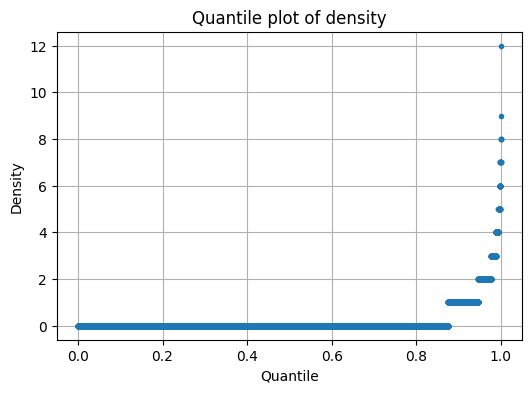

In [75]:
# Trier les données
sorted_density = np.sort(labeled_df["density"])

# Calculer les quantiles (0 à 1)
quantiles = np.arange(1, len(sorted_density)+1) / len(sorted_density)

# Plot
plt.figure(figsize=(6,4))
plt.plot(quantiles, sorted_density, marker='.', linestyle='none')
plt.xlabel("Quantile")
plt.ylabel("Density")
plt.title("Quantile plot of density")
plt.grid(True)
plt.show()

In [1]:
#lat_bin = pd.cut(labeled_df["latitude"], bins=10, labels=False)
#lon_bin = pd.cut(labeled_df["longitude"], bins=10, labels=False)
#time_bin = pd.cut(labeled_df["time"], bins=6, labels=False)

density_bin = pd.qcut(labeled_df["density"], q=5, labels=False)

#strat = lat_bin.astype(str) + "_" + lon_bin.astype(str) + "_" + time_bin.astype(str) + "_" + density_bin.astype(str)

X = labeled_df.drop('density',axis = 1)
Y = labeled_df['density']

print(len(X))
print(len(Y))
print(len(density_bin))

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=None
)
print(X_train.describe())
print(X_test.describe())
print(Y_train.describe())
print(Y_test.describe())

NameError: name 'pd' is not defined